### Assignment: Add Dropout, L2 Regularization, and Early Stopping to the Model



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

Epoch 1/100 => Train Loss: 6.9619 | Test Loss: 2.3327
Epoch 2/100 => Train Loss: 2.4083 | Test Loss: 2.2642
Epoch 3/100 => Train Loss: 2.4924 | Test Loss: 2.2722
Epoch 4/100 => Train Loss: 2.3375 | Test Loss: 2.2931
Epoch 5/100 => Train Loss: 2.3304 | Test Loss: 2.3167
Epoch 6/100 => Train Loss: 2.3314 | Test Loss: 2.2836
Epoch 7/100 => Train Loss: 2.3420 | Test Loss: 2.3281
Epoch 8/100 => Train Loss: 2.3509 | Test Loss: 2.3055
Epoch 9/100 => Train Loss: 2.3332 | Test Loss: 2.2198
Epoch 10/100 => Train Loss: 2.4183 | Test Loss: 2.3150
Epoch 11/100 => Train Loss: 2.2774 | Test Loss: 2.3143
Epoch 12/100 => Train Loss: 2.2651 | Test Loss: 2.3147
Epoch 13/100 => Train Loss: 2.2776 | Test Loss: 2.3322
Epoch 14/100 => Train Loss: 2.3287 | Test Loss: 2.3145
Epoch 15/100 => Train Loss: 2.3025 | Test Loss: 2.3175
Epoch 16/100 => Train Loss: 2.3559 | Test Loss: 2.3149
Epoch 17/100 => Train Loss: 2.3187 | Test Loss: 2.3154
Epoch 18/100 => Train Loss: 2.2893 | Test Loss: 2.3163
Epoch 19/100 => Tra

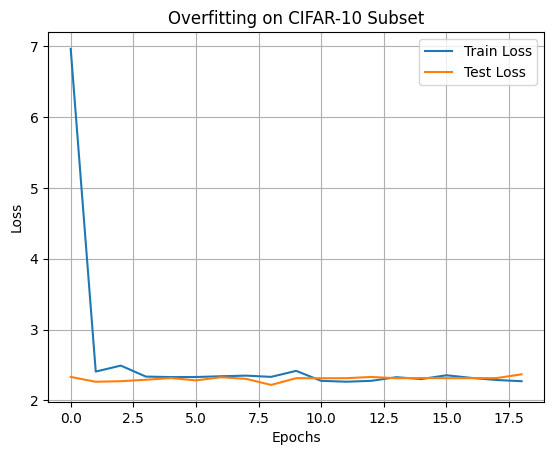

In [ ]:
mean = np.array([0.5,0.5,0.5])
std = np.array([0.5,0.5,0.5])

def custom_transformation(image):
    image = np.array(image).astype(float)/255.0
    image = (image-mean)/std
    image = torch.tensor(image.transpose((2,0,1)),dtype=torch.float32)
    return image

trainset = CIFAR10(root='./task_data',train=True, transform=None, download=True)
testset = CIFAR10(root='./task_data',train=False, transform=None, download=True)

def apply_transform(dataset):
    transformed_data=[]
    for image, label in dataset:
        image_tensor = custom_transformation(image)
        transformed_data.append((image_tensor,label))
    return transformed_data

trainset = apply_transform(trainset)[:500]
testset = apply_transform(testset)[:200]

train_loader = DataLoader(dataset=trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=testset,batch_size=32,shuffle=False)

class OverFitNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3,512)
        self.fc2 = nn.Linear(512,512)
        self.fc3 = nn.Linear(512,10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self,x):
        x=x.view(x.size(0),-1)
        x=self.relu(self.fc1(x))
        x=self.dropout(x)
        x=self.relu(self.fc2(x))
        x=self.dropout(x)
        x=self.fc3(x)
        return x
    
model = OverFitNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.01, weight_decay=1e-4)

train_losses = []
test_losses=[]

epochs = 100
stopping = 10
best_loss = float('inf')
stopping_counter = 0
for epoch in range(epochs):
    train_loss = 0
    model.train()
    for image, label in train_loader:
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, label)  
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            output = model(images)
            loss = criterion(output, labels)
            test_loss += loss.item()
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs} => Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f}")

    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        stopping_counter = 0
        best_model_state = model.state_dict()  
    else:
        stopping_counter += 1
        if stopping_counter >= stopping:
            print(f"Early stopping at epoch {epoch+1}")
            model.load_state_dict(best_model_state)  
            break

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Overfitting on CIFAR-10 Subset")
plt.legend()
plt.grid(True)
plt.show()